# Fraud Detection on Transaction Data

## Data stuff

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir(os.getcwd())
os.chdir("C:/Users/MelodyPogula/Downloads")

In [3]:
### Transaction Data
transaction = pd.read_csv("transaction.csv")
data = transaction.copy()

X = data.drop(columns=["isFraud"])
y = data["isFraud"]

## split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7406
)


In [4]:
### insert identity data cleaning here



identity = pd.read_csv("identity.csv")
merged_df = pd.merge(identity, transaction, on='TransactionID', how='inner')

In [7]:
### Transaction data subset
overlapping_ids = merged_df['TransactionID'].tolist()

transaction_subset = transaction[transaction['TransactionID'].isin(overlapping_ids)]

X_subset = transaction_subset.drop(columns=["isFraud"])
y_subset = transaction_subset["isFraud"]

## subset split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=7406
)

## Light GBM

In [8]:
### Light GBM
params = {
        "objective": "binary",
        "metric": "average_precision",
        "boosting_type": "gbdt",
        "learning_rate": 0.02,     
        "num_leaves": 127,          
        "min_data_in_leaf": 100,  
        "feature_fraction": 0.8,  
        "bagging_fraction": 0.8,   
        "bagging_freq": 1,
        "scale_pos_weight": 10,  
        "verbose": -1
    }

def LGBM(X_train, X_test, y_train, y_test):
    
    # categorical data handle
    object_columns = X_train.select_dtypes(include=['object']).columns
    for col in object_columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')    
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_eval],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    pred_lgb = gbm.predict(X_test)
    pr_auc_lgb = average_precision_score(y_test, pred_lgb)
    return pr_auc_lgb

In [9]:
lgbm_transaction = LGBM(X_train, X_test, y_train, y_test)
print(f"LightGBM PR AUC for Full Transaction Data: {lgbm_transaction:.4f}")

lgbm_transaction_subset = LGBM(X_train_s, X_test_s, y_train_s, y_test_s)
print(f"LightGBM PR AUC for Subset of Transaction Data: {lgbm_transaction_subset:.4f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's average_precision: 0.873088
LightGBM PR AUC for Full Transaction Data: 0.8731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2869]	valid_0's average_precision: 0.927862
LightGBM PR AUC for Subset of Transaction Data: 0.9279


## Cross-Validation

In [10]:
def CV(X_train, y_train, params=params):    
    X_sample = X_train.sample(frac=0.25, random_state=7406)
    y_sample = y_train.loc[X_sample.index]

    cv_results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7406)
    aucs = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X_sample, y_sample)):
        print(f"  Fold {fold + 1}", end=" - ")
        
        X_fold_train, X_fold_val = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
        y_fold_train, y_fold_val = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
        
        # lgb datasets
        lgb_train = lgb.Dataset(X_fold_train, y_fold_train, free_raw_data=False)
        lgb_eval = lgb.Dataset(X_fold_val, y_fold_val, reference=lgb_train, free_raw_data=False)
        
        # model training
        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_eval],
            num_boost_round=5000,
            callbacks=[lgb.early_stopping(stopping_rounds=50) ]
        )
        
        # results
        y_pred = model.predict(X_fold_val, num_iteration=model.best_iteration)
        pr_auc = average_precision_score(y_fold_val, y_pred)
        aucs.append(pr_auc)
        
        print(f"PR AUC: {pr_auc:.5f}")
    cv_results["LightGBM_train"] = aucs    
    return cv_results

In [11]:
cv_transaction = CV(X_train, y_train)
print(f"PR AUCs for Full Transaction Data: {np.round(cv_transaction['LightGBM_train'], 4)}")
print(f"Mean PR AUC for Full Transaction Data: {np.mean(cv_transaction['LightGBM_train']):.4f} ± {np.std(cv_transaction['LightGBM_train']):.4f}")

  Fold 1 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1900]	valid_0's average_precision: 0.713621
PR AUC: 0.71362
  Fold 2 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2686]	valid_0's average_precision: 0.714986
PR AUC: 0.71499
  Fold 3 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1676]	valid_0's average_precision: 0.715362
PR AUC: 0.71536
  Fold 4 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2336]	valid_0's average_precision: 0.727142
PR AUC: 0.72714
  Fold 5 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2214]	valid_0's average_precision: 0.696044
PR AUC: 0.69604
PR AUCs for Full Transaction Data: [0.7136 0.715  0.7154 0.7271 0.696 ]
Mean PR AUC for Full Transaction Data: 0.7134 ± 0.0100


In [12]:
cv_transaction_subset = CV(X_train_s, y_train_s)
print(f"PR AUCs for Full Transaction Data: {np.round(cv_transaction_subset['LightGBM_train'], 4)}")
print(f"Mean PR AUC for Full Transaction Data: {np.mean(cv_transaction_subset['LightGBM_train']):.4f} ± {np.std(cv_transaction_subset['LightGBM_train']):.4f}")

  Fold 1 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1070]	valid_0's average_precision: 0.832663
PR AUC: 0.83266
  Fold 2 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[768]	valid_0's average_precision: 0.821311
PR AUC: 0.82131
  Fold 3 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[696]	valid_0's average_precision: 0.8283
PR AUC: 0.82830
  Fold 4 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[854]	valid_0's average_precision: 0.833606
PR AUC: 0.83361
  Fold 5 - Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[661]	valid_0's average_precision: 0.846923
PR AUC: 0.84692
PR AUCs for Full Transaction Data: [0.8327 0.8213 0.8283 0.8336 0.8469]
Mean PR AUC for Full Transaction Data: 0.8326 ± 0.0084


### Summary Graphs

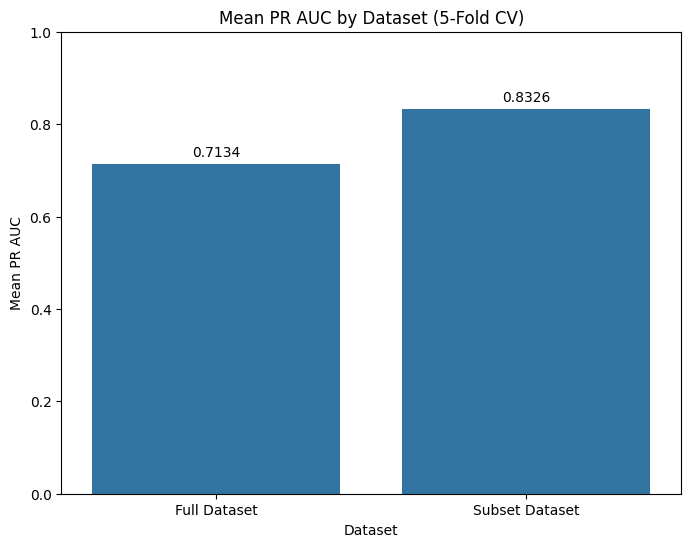

In [ ]:
# Calculate mean AUC for each dataset
mean_full = np.mean(cv_transaction['LightGBM_train'])
mean_subset = np.mean(cv_transaction_subset['LightGBM_train'])

mean_aucs = {
    'Full Dataset': mean_full,
    'Subset Dataset': mean_subset
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(mean_aucs.keys()), y=list(mean_aucs.values()))
plt.title("Mean PR AUC by Dataset (5-Fold CV)")
plt.xlabel("Dataset")
plt.ylabel("Mean PR AUC")

# bar labels
for i, (dataset, mean_auc) in enumerate(mean_aucs.items()):
    plt.text(i, mean_auc + 0.01, f'{mean_auc:.4f}', 
             ha='center', va='bottom')

plt.ylim(0, 1)
plt.show()